## Using dask for EODC items

In this notebook we are going to take a look at stac items we retrieved from EODC and try to adapt some dask worklow to it. The two cores of the dask library we are going to use are parallel processing and lazy loading. These two functions tie smoothly into our workflow because they allow us to keep working with stac items and their quality of just being mata data. That means that we can create a nice worklow without actually downloading any real data into our local RAM or memory. 

In [1]:
#These are the important packages we first need to import 

import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import pystac
from pystac_client import Client
from odc import stac as odc_stac
from odc.geo.geobox import GeoBox
from affine import Affine
import sys

import dask.dataframe as dd
import dask.array as da
import time

In [2]:
#The code here adjusts the width of the nootebook display container

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Get stac items from EODC catalogue

In [3]:
#This is how we access the AI4SAR collection via the stac_api

stac_api = "https://stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="AI4SAR_SIG0"

In [4]:
#Next we search for certain items in the AI4SAR_SIG0 collection, defining the area and time period
collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-10-31"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
q_items = sorted(query.items(), key=lambda x: x.id)

In [5]:
for item in q_items:
    print(item)

print("\n","The length of the list of items is",len(q_items))



<Item id=SIG0_20230418T050210_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230512T050211_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230617T050213_D124_EU020M_E051N015T3_S1AIWGRDH>

 The length of the list of items is 3


In [6]:
#Here we take a look at the metadata of one item.

q_items[0].properties

{'gsd': 20,
 'datetime': '2023-04-18T05:02:10Z',
 'proj:bbox': [5100000, 1500000, 5400000, 1800000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5100000.0, 1500000.0],
    [5100000.0, 1800000.0],
    [5400000.0, 1800000.0],
    [5400000.0, 1500000.0],
    [5100000.0, 1500000.0]]]},
 'proj:transform': [20, 0, 5100000, 0, -20, 1800000],
 'sat:orbit_state': 'descending',
 'sar:product_type': 'GRD',
 'sar:frequency_band': 'C',
 'sat:rel

## Get dask started

First it all starts with creating and connecting to a client which helps us to submit tasks, monitor processes and retrieve results. The neat thing is that our client could be connected to any scale of computational power. We could either connect it with our local pc, a high performance computer (HPC) or a cloud optimized platform. For now we are going to connect our client with our local pc or so called local cluster.

In [7]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.24 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38387,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.24 GiB
Comm: tcp://127.0.0.1:45429,Total threads: 4
Dashboard: http://127.0.0.1:39303/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:40613,


If we look at the cluster info there are several important keywords for us to understand. Like for example workers which are responsible for executing the actual computations. They fetch tasks from the scheduler, process the tasks, and then return the results. By default, Dask often configures one worker per CPU core, but this can be adjusted. Threads are smaller units of processing that run within workers, enabling parallel execution within the same worker process. Workers operate as independent processes, each with their own memory space, while threads share the same memory space within a worker, allowing for efficient data sharing and concurrent execution.

## Xarray vs. dask array



In order to create a worklow with our new local dask cluster we are getting back to our stac items and look at  two possibilites of storing the items in our RAM either as xarray or dask array.


In [8]:
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree
sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

The quality of an xarray is a very flexible overview and workflow with many kinds of dimensions. In this case the dimensions we get from our items are latitude, longitude and time plus two data variables VV and VH polarisation which could also be seen as another two dimensions. Working with an xarray we can easily retrieve the data with need as new array and do array based computations. The drawback is that we are limited when it comes to computational power. 

In [9]:
#Looking at the Xarray
sig0_ds

<xarray.Dataset> Size: 371MB
Dimensions:      (latitude: 5556, longitude: 5557, time: 3)
Coordinates:
  * latitude     (latitude) float64 44kB 48.7 48.7 48.7 48.7 ... 47.7 47.7 47.7
  * longitude    (longitude) float64 44kB 15.6 15.6 15.6 15.6 ... 16.6 16.6 16.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2023-04-18T05:02:10 ... 2023-06-17...
Data variables:
    VV           (time, latitude, longitude) int16 185MB -9999 -9999 ... -97 -97
    VH           (time, latitude, longitude) int16 185MB -9999 -9999 ... -165

Compared to an xarray a dask array is not that handy when it comes to handling dimensions. We have to give it a little more thought and look at how we could put the xarray in so called chunks. If we define how big one chunk should be the whole xarray gets divided into several almost equally big chunks. This way dask can distribute the chunks equally on the workers when it comes to computation and thereby parallel computing becomes more easy which in the end means that our computational power is used in the most effective way. Dask might not look as handy as xarray when it comes to handling dimensions but it is a powerful tool to handle big amounts of data thinking about big xarrays or any other kind of big data. 

## Chunk it up

Here we look at two different ways of chunking up our Xarray. It is to be said that we will just look at the VV polarised data values because we can not put both data variables into one single dask array. 

In [10]:
#This way we create the dask array with the chunk size of 'latitude': 5556,'longitude': 5557 and 'time': 1
#This means our array will be divided into three parts

sig0_ds_chunked1=sig0_ds.chunk({'latitude': 5556,'longitude': 5557,'time': 1})

sig0_VV_da1 = sig0_ds_chunked1['VV'].data

display(sig0_VV_da1)


dask.array<xarray-VV, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 5556, 5557), chunktype=numpy.ndarray>

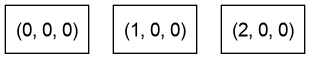

In [11]:
#This is a very basic visual representation of how our dask cluster recognises the three chunks
sig0_VV_da1.visualize()

In [12]:
#To have some comparison we chunk up the xarray in a different way.
#Now we create the dask array with the chunk size of 'latitude': 1000,'longitude': 1000 and 'time': 1
#This means our array will be divided into 6*6*3= 108 chunks

sig0_ds_chunked2=sig0_ds.chunk({'latitude':1000,'longitude':1000,'time':1})

sig0_VV_da2=sig0_ds_chunked2['VV'].data

display(sig0_VV_da2)



dask.array<xarray-VV, shape=(3, 5556, 5557), dtype=int16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

In [13]:
#This is a very basic visual representation of how our dask cluster recognises the 108 chunks
sig0_VV_da2.visualize(format='svg')

The big question now would be how we even know which size we should choose for the chunks? Unfortunately or fortunately there is no clear answer to this question. We have to find out ourselves what chunk size is the most effective one depending on the data and the algorithms we use. In the next parts we look at what difference it could make in computational time depending on the chunk size we choose.

## Parallel computing and lazy loading

In this part we plan our first operations on the dask array. In doing so we get to know the two core functions of dask parallel computing and lazy loading a little bit better.  

At first it is really more about planning a computation than executing it. As example the first operation we try  is to filter the bad values of our first dask array sig0_VV_da1 which is split in three chunks. If we already know our data a little bit better we can easily remove these bad values in our case -9999. 

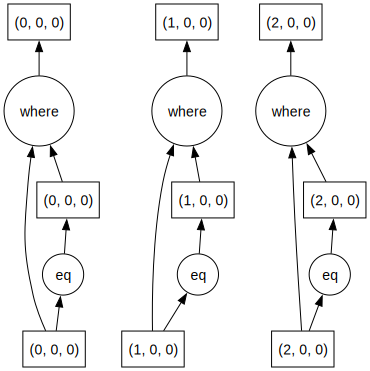

In [14]:
#Planning the operation
sig0_VV_da1=da.where(sig0_VV_da1==-9999,0,sig0_VV_da1)

#Visualizing the plan
sig0_VV_da1.visualize(format='svg')

So what we see here is a plan of how the computation of this operation would look like for our dask cluster if we  would actually compute it which means we did not compute anything yet. We could call it a computing plan. This computing plan might look a little confusing on first sight but the most important take away is that the dask cluster could compute the operation (replacing the bad values) parallely on the three chunks we defined.

To have a comparison we try to apply the same operation on our second dask array sig0_VV_da2 that we split into 108 chunks.

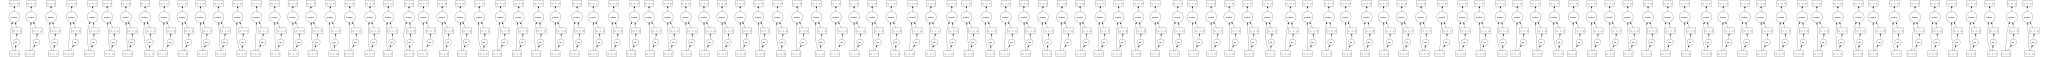

In [15]:
#Planning the operation
sig0_VV_da2=da.where(sig0_VV_da2==-9999,0,sig0_VV_da2)

#Visualizing the plan
sig0_VV_da2.visualize(format='svg')


What we see on this computing plan is almost the same as in the first one with the only difference that our dask cluster would execute 108 chunks parallely instead of three.

## Computing time

Now we come back to where we left off in the part 'Chunk it up'. In order to see what real difference it makes the way we chunk up our xarray we take a look at the computational time our filter operation needs for each dask array sig0_VV_da1 and sig0_VV_da2. Consequently we finally have to execute our computing plan which means we finally compute.

In [17]:
%%time
sig0_VV_da1.compute()

/home/jlinke/miniconda3/envs/EODC/lib/python3.12/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 176.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 182 ms, sys: 303 ms, total: 484 ms
Wall time: 509 ms


array([[[   0,    0,    0, ..., -103, -100, -100],
        [   0,    0,    0, ..., -104, -101, -101],
        [   0,    0,    0, ..., -102, -100, -100],
        ...,
        [-169, -169, -169, ...,  -87,  -97, -103],
        [-163, -163, -163, ...,  -95,  -96,  -98],
        [-144, -147, -151, ..., -100,  -96,  -96]],

       [[   0,    0,    0, ...,  -85,  -85,  -85],
        [   0,    0,    0, ...,  -85,  -86,  -86],
        [   0,    0,    0, ...,  -88,  -89,  -89],
        ...,
        [-135, -139, -140, ...,  -89,  -91,  -95],
        [-132, -137, -138, ...,  -92,  -93,  -93],
        [-126, -135, -135, ...,  -96,  -93,  -93]],

       [[   0,    0,    0, ..., -101, -100, -100],
        [   0,    0,    0, ..., -100, -100, -100],
        [   0,    0,    0, ..., -100, -102, -102],
        ...,
        [-128, -135, -129, ...,  -91,  -88,  -92],
        [-124, -133, -126, ...,  -95,  -93,  -95],
        [-118, -131, -121, ...,  -99,  -97,  -97]]], dtype=int16)

When the computation is finished we look at three different times that have been counted. The user time is how long the CPU takes to do the actual computation, sys time is how long information is transferred in and out of the CPU and wall time is how long we witness the whole process from the outside which can also include delays.

The CPU should not be confused with the dask client. Both are responsible for coordination but on different levels. The dask client is responsible for the coordination on a higher level within the software domain, coordinating between multiple CPUs or other computing resources.The CPU is responsible for the coordination on a lower level we could say the hardware level where it comes to controlling the cores and doing the real computation.

In [ ]:
%%time
sig0_VV_da2.compute()

/home/jlinke/miniconda3/envs/EODC/lib/python3.12/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 176.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 723 ms, sys: 340 ms, total: 1.06 s
Wall time: 1.06 s


array([[[   0,    0,    0, ..., -103, -100, -100],
        [   0,    0,    0, ..., -104, -101, -101],
        [   0,    0,    0, ..., -102, -100, -100],
        ...,
        [-169, -169, -169, ...,  -87,  -97, -103],
        [-163, -163, -163, ...,  -95,  -96,  -98],
        [-144, -147, -151, ..., -100,  -96,  -96]],

       [[   0,    0,    0, ...,  -85,  -85,  -85],
        [   0,    0,    0, ...,  -85,  -86,  -86],
        [   0,    0,    0, ...,  -88,  -89,  -89],
        ...,
        [-135, -139, -140, ...,  -89,  -91,  -95],
        [-132, -137, -138, ...,  -92,  -93,  -93],
        [-126, -135, -135, ...,  -96,  -93,  -93]],

       [[   0,    0,    0, ..., -101, -100, -100],
        [   0,    0,    0, ..., -100, -100, -100],
        [   0,    0,    0, ..., -100, -102, -102],
        ...,
        [-128, -135, -129, ...,  -91,  -88,  -92],
        [-124, -133, -126, ...,  -95,  -93,  -95],
        [-118, -131, -121, ...,  -99,  -97,  -97]]], dtype=int16)

At last we also take a look at how much time we need to compute our data as one big chunk.

In [19]:
one_big_chunk=sig0_ds['VV'].data
one_big_chunk=da.where(one_big_chunk==-9999,0,one_big_chunk)



In [20]:

%%time
one_big_chunk.compute()

/home/jlinke/miniconda3/envs/EODC/lib/python3.12/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 265.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 268 ms, sys: 357 ms, total: 625 ms
Wall time: 702 ms


array([[[   0,    0,    0, ..., -103, -100, -100],
        [   0,    0,    0, ..., -104, -101, -101],
        [   0,    0,    0, ..., -102, -100, -100],
        ...,
        [-169, -169, -169, ...,  -87,  -97, -103],
        [-163, -163, -163, ...,  -95,  -96,  -98],
        [-144, -147, -151, ..., -100,  -96,  -96]],

       [[   0,    0,    0, ...,  -85,  -85,  -85],
        [   0,    0,    0, ...,  -85,  -86,  -86],
        [   0,    0,    0, ...,  -88,  -89,  -89],
        ...,
        [-135, -139, -140, ...,  -89,  -91,  -95],
        [-132, -137, -138, ...,  -92,  -93,  -93],
        [-126, -135, -135, ...,  -96,  -93,  -93]],

       [[   0,    0,    0, ..., -101, -100, -100],
        [   0,    0,    0, ..., -100, -100, -100],
        [   0,    0,    0, ..., -100, -102, -102],
        ...,
        [-128, -135, -129, ...,  -91,  -88,  -92],
        [-124, -133, -126, ...,  -95,  -93,  -95],
        [-118, -131, -121, ...,  -99,  -97,  -97]]], dtype=int16)

When we compare the wall time of each computation we see that it took 509 ms for sig0_VV_da1, 1060 ms for sig0_VV_da2 and 702 ms for one_big_chunk. Which means that the xarray that was split into three chunks was the fastest computation for our dask cluster. This could maybe have to do that we have close to three cores and not close to 108 cores. 